<div style="background-color:#009440; padding: 0px; background-size:cover; background-opacity:50%; border-radius:5px; height:300px">
    <div style="margin: 5px; padding: 10px;">
    <h1 style="color:#00000">Geophysical Data Acquisition and Analysis</h1>
    <h5 style="color:#C0C0C0">LMU, 06 August 2019</h5>
    <h4 style="color:rgba(0,0,0,0.6)">Sebastian Anger, Tobias, Megies, Taufiqurrrahman, Alice Gabriel</h4>
    </div>
    <div style="float:right; margin: 20px; padding: 20px; background:rgba(255,255,255,0.7); width: 70%; height: 100px">
      <div style="position:relative; top:40%; transform: translateY(-50%)">
        <div style="font-size: x-large; font-weight:900; color:rgba(0,0,0,0.8); line-height:100%">P04 - Fourier Series & Transformation</div>
        </div>
    </div>
</div>

**Again, please execute the following cell first!**

In [1]:
# Cell 0 - Preparation: load packages, set some basic options  
%matplotlib inline
from __future__ import print_function
from scipy import signal
from obspy.signal.invsim import cosine_taper 
from matplotlib import rcParams
import numpy as np
import warnings
warnings.filterwarnings('ignore')                  # do not show warnings
import matplotlib.pylab as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15, 3

### Exercise 1: The Fourier series and its coefficients 

In the following two code cells, we first define a function which calculates the coefficients of the Fourier series for a given function. The function in the next cell does it the other way round: it is creating a function based on given coefficients and weighting factors.

In [2]:
# Cell 1: code by Giulio Ghirardo  
def fourier_series_coeff(f, T, N):
    """Calculates the first 2*N+1 Fourier series coeff. of a periodic function.

    Given a periodic, function f(t) with period T, this function returns the
    coefficients a0, {a1,a2,...},{b1,b2,...} such that:

    f(t) ~= a0/2+ sum_{k=1}^{N} ( a_k*cos(2*pi*k*t/T) + b_k*sin(2*pi*k*t/T) )
    
    Parameters
    ----------
    f : the periodic function, a callable like f(t)
    T : the period of the function f, so that f(0)==f(T)
    N_max : the function will return the first N_max + 1 Fourier coeff.

    Returns
    -------
    a0 : float
    a,b : numpy float arrays describing respectively the cosine and sine coeff.
    """
    # From Nyquist theorem we must use a sampling 
    # freq. larger than the maximum frequency you want to catch in the signal. 
    f_sample = 2 * N
    
    # We also need to use an integer sampling frequency, or the
    # points will not be equispaced between 0 and 1. We then add +2 to f_sample.
    t, dt = np.linspace(0, T, f_sample + 2, endpoint=False, retstep=True)
    y = np.fft.rfft(f) / t.size
    y *= 2
    return y[0].real, y[1:-1].real[0:N], -y[1:-1].imag[0:N]

In [3]:
# Cell 2: code by Giulio Ghirardo  
def series_real_coeff(a0, a, b, t, T):
    """calculates the Fourier series with period T at times t,
       from the real coeff. a0,a,b"""
    tmp = np.ones_like(t) * a0 / 2.
    for k, (ak, bk) in enumerate(zip(a, b)):
        tmp += ak * np.cos(2 * np.pi * (k + 1) * t / T) + bk * np.sin(
            2 * np.pi * (k + 1) * t / T)
    return tmp

---  
Now, we can create an arbitrary function, which we use to experiment with in the following example. Play around with the number of coefficients N.   
  

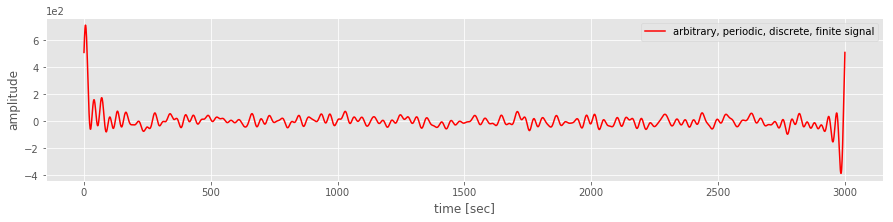

In [12]:
# Cell 3: create periodic, discrete, finite signal

# number of samples (intial value: 3000)
samp = 3000
# sample rate (initial value: 1)
dt = 1
# period
T = 1.0 / dt
length = samp * dt
# number of coefficients (initial value: 100)
N = 100
# weighting factors for coefficients (selected randomly)
a0 = np.random.rand(1)
a = np.random.randint(1, high=11, size=N)
b = np.random.randint(1, high=11, size=N)

t = np.linspace(0, length, samp)             # time axis
sig = series_real_coeff(a0, a, b, t, T)

# plotting
plt.plot(t, sig, 'r', label='arbitrary, periodic, discrete, finite signal')
plt.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
plt.xlabel('time [sec]')
plt.ylabel('amplitude')
plt.legend()
plt.show()

---  
Now, we can play with the signal and see what happens when we try to reconstruct it with a limited number of coefficients.  

- Run the cells 4 and 5. What do you observe?  
- Increase the number of coefficients $n$ step by step and re-run cells 4 and 5. What do you observe now? Can you explain?   

In [9]:
# Cell 4: determine the first 'n' coefficients of the function using the code function of cell 1
T = 1        # period
n = 20        # number of coeffs to reconstruct
a0, a, b = fourier_series_coeff(sig, T, n)
a_ = a.astype(int)
b_ = b.astype(int)
print('coefficient a0 = ', int(a0))
print('array coefficients ak =', a_)
print('array coefficients bk =', b_)

coefficient a0 =  71
array coefficients ak = [ 98 599 384 313 312 244 100 390 600 244 100 606 103 605 320 754 674 253
 610 455]
array coefficients bk = [358 572 501 358 145 717 289 715 284 431  77 571 291 356 361 710 424 716
 634 137]


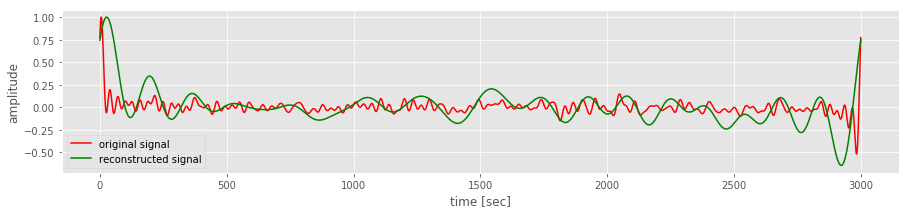

In [10]:
# Cell 5: reconstruct the function using the code in cell 2
g = series_real_coeff(a0, a, b, t, dt)

# plotting
#plt.plot(t, sig, 'r', label='original signal')          # NOT normalized 
#plt.plot(t, g, 'g', label='reconstructed signal')
plt.plot(t, sig/max(sig), 'r', label='original signal')  # normalized 
plt.plot(t, g/max(g), 'g', label='reconstructed signal')

plt.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
plt.xlabel('time [sec]')
plt.ylabel('amplitude')
plt.legend()
plt.show()

---

### Exercise 2: Fourier series, convergence and Gibb's phenomenon

As seen above the convergence of the *Fourier series* can be tricky. To analyse this effect in a bit more detail, we define a square wave in cell 6 and try to reconstruct it in cell 7.  

- First, we use only 5 coefficients to reconstruct the wave. Describe what you see.  
-  Increase the number of coefficients $n$ in cell 7 step by step and re-run the cell.  What do you see now? Can you explain it?

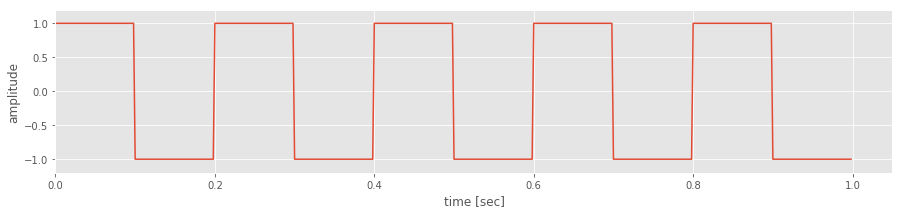

In [13]:
# Cell 6: define a square wave of 5 Hz
freq = 5.
npts = 500
dt_ = 0.002
length = npts * dt_
t_ = np.linspace(0, length, npts, endpoint=False)
square = signal.square(2 * np.pi * freq * t_)

plt.plot(t_, square)
plt.xlabel('time [sec]')
plt.ylabel('amplitude')
plt.xlim(0, 1.05)
plt.ylim(-1.2, 1.2)
plt.show()

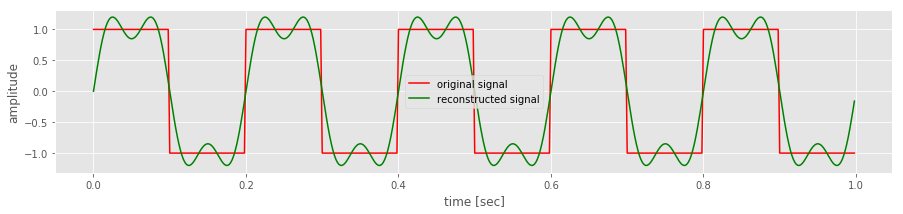

In [15]:
# Cell 7: reconstruct signal using convergence criterion
n =5                  # number of coefficients (initial: 5)
T_ = 1/freq           # period of signal

# determine coefficients
a0 = 0
a = []
b = []
for i in range(1,n):
    if (i%2 != 0):
        a_ = 4/(np.pi*i)
    else:
        a_ = 0
    a.append(a_)
    b_ = (2*np.pi*i)/T_
    b.append(b_)

# reconstruct signal
g = np.ones_like(t_) * a0
for k, (ak, bk) in enumerate(zip(a, b)):
    g += ak * np.sin(bk*t_)

# plotting
plt.plot(t_, square, 'r', label='original signal')                  
plt.plot(t_, g, 'g', label='reconstructed signal')
plt.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
plt.xlabel('time [sec]')
plt.ylabel('amplitude')
#plt.ylim(-1.1,1.1)
plt.legend()
plt.show()

---

### Exercise 3: Fourier transformation

Let us now do the Fourier transformation of the signal created in cell 3 and have a look on the amplitude spectra. In computer science the transformation is performed as fast Fourier transformation (FFT).    

-  How do you interpret the plot of the amplitude spectra?  
- Which frequency contributes most to the final signal?   

samp = 3000  Need to be the same as in cell 3.
T = 1.0  Need to be the same as in cell 3.


Text(0,0.5,'Amplitude')

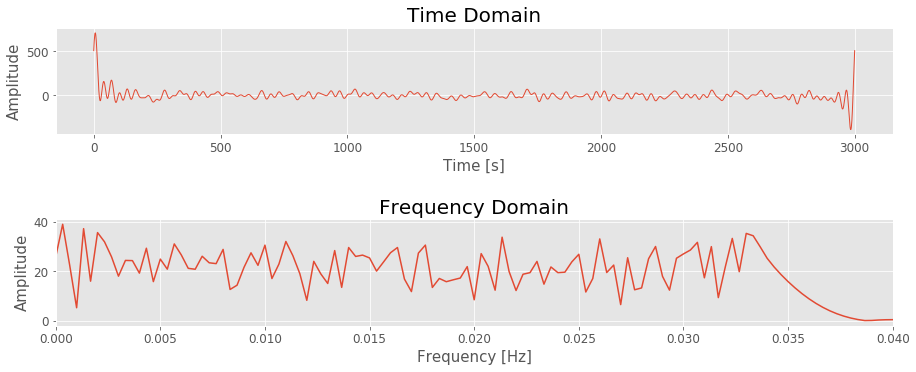

In [18]:
# Cell 8: FFT of signal
# number of sample points need to be the same as in cell 3
print('samp =',samp,' Need to be the same as in cell 3.')
# number of sample points need to be the same as in cell 3
print('T =',T,' Need to be the same as in cell 3.')
# percentage of taper applied to signal (initial: 0.1)
taper_percentage = 0.1
taper = cosine_taper(samp,taper_percentage)

sig_ = sig * taper
Fsig = np.fft.rfft(sig_, n=samp)

# prepare plotting
xf = np.linspace(0.0, 1.0/(2.0*T), (samp/2)+1)
rcParams["figure.subplot.hspace"] = (0.8)
rcParams["figure.figsize"] = (15, 9)
rcParams["axes.labelsize"] = (15)
rcParams["axes.titlesize"] = (20)
rcParams["font.size"] = (12)
 
#plotting
plt.subplot(311)
plt.title('Time Domain')
plt.plot(t, sig, linewidth=1)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(312)
plt.title('Frequency Domain')
plt.plot(xf, 2.0/npts * np.abs(Fsig))
plt.xlim(0, 0.04)                                
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')